# Purpose

This notebook is a working exploration of classification algorithms.

# MNIST Dataset

MNIST dataset is a set of 70,000 small images of digits handwritten by highschool students.  It is a commonly studied dataset for classification problems.  I'll access it via `sklearn`.   

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Separating out the features and target variable.

In [3]:
X, y = mnist["data"], mnist["target"]
#forcing to numpy array
X = X.to_numpy()
y = y.to_numpy()

print("X shape: {}, y shape: {}".format(X.shape, y.shape))

X shape: (70000, 784), y shape: (70000,)


There are 70,000 images (rows) and each have 784 features (columns) because each image is 28 x 28 pixels and each feature simply represents each pixel's intensity froom 0 (white) to 255 (black).  I can look at an individual image using `matplotlib`'s `imshow()` function.

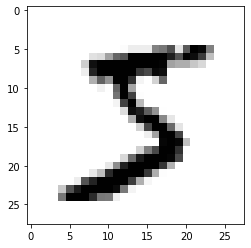

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.show()

This digit looks like a 5 to me and below I'm confirming that is in fact how it is labeled.  Notice the label is a string, so I'm also going to cast y to integer.

In [5]:
import numpy as np
print('image label: {}, label type: {}'.format(y[0], type(y[0])))

y = y.astype(np.uint8)

image label: 5, label type: <class 'str'>


Of course, before I do any EDA work I want to split out a test dataset.  In the case of the MNIST dataset, this is already separated for me.  The first 60,000 images are my training set and the final 10,000 are my test set.  The training set is already shuffled, which is good in this case but would not be in some other cases, e.g. time series, because it ensures all CV folds will contain similar digits.

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

First, I'm going to simplify the problem by training a binary classifier to look for the digit 5.  I'll begin with a _Stochastic Gradient Descent_ (SGD) classifier using `SGDClassifier` from Scikit-Learn and simply train it on the entirety of our binary 5 dataset.

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=33)
sgd_clf.fit(X_train, y_train_5)

print("Does my model predict a 5 for the some_digit example above? {}".format(sgd_clf.predict([some_digit])))

Does my model predict a 5 for the some_digit example above? [ True]


# Performance Measures

Measuring performance of a classifier can be quite a bit trickier than measuring perfoormance of a regressor so I'm going to go through several topics here.

## Measuring Accuracy Using Cross-Validation

A reasonable first step is to measure accuracy using cross-fold validation similar to the process from the previous chapter.

In [8]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.913  , 0.9674 , 0.95865])

Those accuracy measures may look high but it's important to remember how limited accuracy can be when we're dealing with classifiers.  In order to prove this point I'm going to make a dumb classifier below which simply predicts False everywhere, e.g. all digits are "not 5", and compare the accuracy measures to the above model.

In [9]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

The accuracy of the dumb model above is above 90% and that's because roughly 10% of the digits in the training set are 5.  This illustrates why more care is needed in evaluating the performance of classifiers, especially when dealing with _skewed datasets_, i.e. when some classes are much more frequent than others.

## Confusion Matrix

A better way to evaluate a classifier is to use the confusion matrix, which is a matrix that contains comparisons of all 4 possible outcomes (for a binary classifier).  In order to generate the confusion matrix, I'll first predict along my entire training set using `cross_val_predict` and then use Sci-kit Learn's `confusion_matrix()`.  

Each row in a confusion matrix represents an _actual class_ and each column represents a _predicted class_.  In our example below, the first row represents non-5 images (the _negative class_).  Column 1 tells us that 52,663 were correctly identified as non-5 digits (_true negative_) and column 2 tells us that 1,916 were incorrectly identified as 5s (_false positive_).  The second row represents images of 5s (the _positive class_).  Column 1 tells us that 1,303 were incorrectly identified as non-5 images (_false negative_) and 4,118 were correctly identified as 5s (_true positive_).  A perfect classifier would only contain true positives and true negatives so it would only contain nonzeros in its main diagonal, top left to bottom right.

In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print("Confusion Matrix:\n{}".format(confusion_matrix(y_train_5, y_train_pred)))

Confusion Matrix:
[[52663  1916]
 [ 1303  4118]]


## Precision, Recall, and F1 Score

The confusion matrix displays a lot of information about the classifier's performance, especially for multi-class classifiers, but when you want a more concise measure of performance, precision and recall are typically used.  Precision is a measure of how many of the positive predictions are correct ($\frac {TP}{TP + FP}$) and recall, or sensitivity, is the ratio of positive instances that are correctly detected by the classifier ($\frac {TP}{TP + FN}$).  A convenient way to combine precision and recall is the $F_1$ score, which takes the harmonic mean of precision and recall.  The harmonic mean gives much more weight to low values than the standard mean weights all values the same, therefore a classifier will only have a high $F_1$ score if both precision and recall are high.

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

msg = f'''
Precision: {precision_score(y_train_5, y_train_pred)}
Recall: {recall_score(y_train_5, y_train_pred)}
F1 Score: {f1_score(y_train_5, y_train_pred)}
'''
print(msg)


Precision: 0.6824660258534968
Recall: 0.7596384430916805
F1 Score: 0.7189873417721518



$F_1$ score favors classifiers that have similar precision and recall though this might not always be what you want.  For example if you were training a classifier to detect which videos are suitable for children, you'd likely prefer a classifier that rejects some good videos (low recall) but keeps only safe ones (high precision).  Similarly if you were training a classifier to catch shoplifters you'd likely care about the opposite.

## Precision/Recall Tradeoff

Precision and recall are necessarily inversely related, by raising one you must lower the other.  To alter this relationship you must adjust the thershold by which the classifier determines the class.  Sci-kit Learn does not let you adjust this threshold directly, though it does let you output the decision threshold using the `decision_function()` method.  Then you can simply define your own threshold for class determination.

In [12]:
y_some_digit_decision = sgd_clf.decision_function([some_digit])

msg = f'''
Class at threshold = 0: {y_some_digit_decision > 0}
Class at threshold = 1000: {y_some_digit_decision > 1000}
'''

print(msg)


Class at threshold = 0: [ True]
Class at threshold = 1000: [False]



Above, I'm raising the threshold from zero (the default) to 1,000 and I can see that this changes my prediction from "5" to "not 5", lowering recall.  In order to see how threshold selection affects precision and recall over all possible options, I'm going to use `cross_val_predict()` and `decition_function()` to predict across the entire training set, then `precision_recall_curve()` to generate and plot all possible selections.

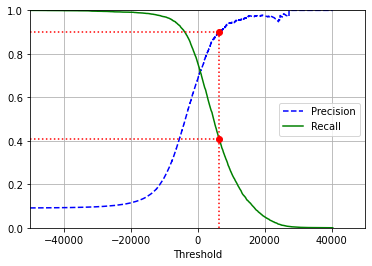

In [13]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="right")
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

#determine recall and threshold at 90% precision for plot highlighting
#np.argmax gives me the first index of the max value, in this case the first True value
#because recalls is ordered from largest to smallest, this gives me the largest recall at 90% precision
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
#because thresholds is ordered from smallest to largest, this gives me the smallest threshold at 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

#add highlighted 90% precision selection
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             

plt.show()

Another way to select the best tradeoff is to plot precision as a function of recall directly.

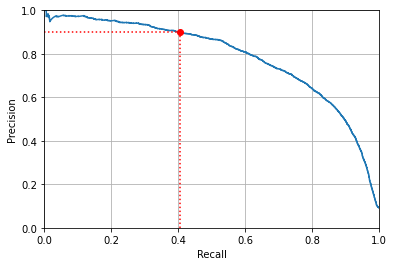

In [14]:
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0,1,0,1])
plt.grid(True)

#highlight the same 90% precision point
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")

plt.show()

## ROC Curve

Another common performance measure for binary classifiers is the _receiver operating characteristic_ (ROC) curve.  The ROC curve plots the _true positive rate_ (TPR or recall) against the _false positive rate_ (FPR).  We can get FPR and TPR at all relevant thresholds using Sci-kit Learn's `roc_curve()` and then plot them using matplotlib in order to take a look at the ROC curve.

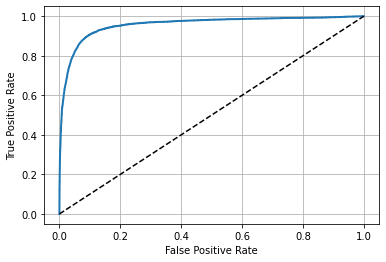

In [15]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') #dashed diagonal 1:1 line for comparison
    plt.grid(True)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

plot_roc_curve(fpr, tpr)
plt.show()

The ROC curve further illustrates the trade off; the higher the recall (TPR), the more false positives (FPR) the classifier produces.  The dashed 1:1 line represents a random classifier.  A good classifier should stay as far away as possible from this line, in the upper left corner of the plot.  One way to compare classifiers is to measure the _area under the curve_ (AUC).  A perfect classifier has an AUC equal to 1.  AUC can be calculated using Sci-kit Learn's `roc_auc_score()`.

In [16]:
from sklearn.metrics import roc_auc_score
print("AUC: ", roc_auc_score(y_train_5, y_scores))

AUC:  0.9565951186469316


A good rule of thumb when determining which to use between the precision/recall (PR) curve and the ROC curve is that you should prefer the PR curve whenever the positive class is rare or when you care more about false positives than false negatives.  Otherwise, use the ROC curve.  Taking our example above, the ROC curve makes the classifier look fairly decent because the rate of true 5s in the dataset is quite low.

Now I'll train a `RandomForestClassifier` and compare it to the `SDGClassifier` above.  In order to generate the scores for the `RandomForestClassifier` I'll have to use its `predict_proba()` method.  

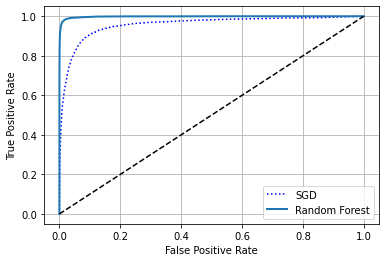


SGD AUC = 0.9565951186469316
RF AUC = 0.9982396047484723



In [17]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=33)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

#predict_proba gives a column for the probability of each class
#choosing the second column as the score = prob of positive class
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

#comparing ROC curves
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

#comparing AUC
msg = f'''
SGD AUC = {roc_auc_score(y_train_5, y_scores)}
RF AUC = {roc_auc_score(y_train_5, y_scores_forest)}
'''
print(msg)


It's pretty clear from both the ROC curve and the AUC that the `RandomForestClassifier` is superior to the `SGDClassifier` at predicting 5s.  Now lets try to predict more than 5s!

# Multiclass Classification

Some classification algorithms are natively capable of multiple classes natively, e.g. SGD, Random Forest, naive Bayes.  Others are strictly binary, e.g. Logistic Regression, SVM, and there are various strategies to use them to train multiclass classifiers.  The two most common are _one-versus-the-rest_ (OvR), also called _one-versus-all_ and _one-versus-one_ (OvO).  The OvR strategy trains one binary classifier for each class, runs any new prediction through all classifiers, and then chooses the class with the highest decision score.  The OvO strategy trains a classifer for each pair of classes, so for $N$ classes that's $N x (N-1) / 2$ classifiers or 45 classifiers in the case of our 10 digit example dataset.  Then when you want to classify a new image you have to run all 45 classifiers and see which class wins the most duels.  The main advantage of OvO is that each classifier only needs to be trained on subset which contains the two relevant classes.  This means it is far better for some algorithms which do not scale well with large training sets, like SVM. For most cases, however, OvR is preferred.

Sci-kit Learn detects when you use a binary classifier for multiclass classification and automatically applies OvR or OvO depending on the algorithm.

In [18]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
print("Should be 5: ", svm_clf.predict([some_digit]))

Should be 5:  [5]


As mentioned earlier Sci-kit Learn automatically applies OvO under the hood to train the `SVC` on the original training set and in this case correctly predicts the digit 5.  If you use the `decision_function()` method you can see that it does in fact return 10 scores, one for each class of digit and the highgest score does correspond to 5.

In [19]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_class = svm_clf.classes_[np.argmax(some_digit_scores)]
print(f'''
Class Scores: {some_digit_scores}
Predicted Class: {some_digit_class}
''')


Class Scores: [[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
Predicted Class: 5



If you instead want to force Sci-kit Learn to use OvR or OvO then you can use the `OneVsOneClassifier` or `OneVsRestClassifier` classes.  Below I'll illustrate by forcing our `SVC` example from above into OvR.

In [20]:
from sklearn.multiclass import OneVsRestClassifier
svm_ovr_clf = OneVsRestClassifier(SVC())
svm_ovr_clf.fit(X_train, y_train)

some_digit_class = svm_ovr_clf.predict([some_digit])
num_estimators = len(svm_ovr_clf.estimators_)
print(f'''
Predicted Class: {some_digit_class}
Number of Estimators: {num_estimators}
''')


Predicted Class: [5]
Number of Estimators: 10



Training a `SGD` or `RandomForestClassifier` is just as easy and these algorithms handle multiclass natively so there's no need for OvR or OvO.

In [21]:
sgd_clf.fit(X_train, y_train)
some_digit_class = sgd_clf.predict([some_digit])
some_digit_scores = sgd_clf.decision_function([some_digit])

print(f'''
Predicted Class: {some_digit_class}
Class Scores: {some_digit_scores}
''')


Predicted Class: [5]
Class Scores: [[-17162.37078339 -27015.81724342 -10267.25715433    845.35462364
  -27661.42713144   4975.89518679 -21944.72449229 -16589.79224104
  -16109.67237514 -15487.30537608]]



In this case we can see that the `SGD` is quite confident in it's prediction of 5 as the score for 5 is very high and most other scores are large negative numbers, aside from class 3.  Now I'll use `cross_val_score()` again to take a look at the classifier's accuracy.

In [22]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.8703, 0.8774, 0.8778])

87% accuracy across all folds is quite good when you consider a random classifier would have 10% accuracy in this case.  In fact, we can further improve the accuracy by simply scaling the training set.

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.9007 , 0.88985, 0.90135])

# Error Analysis

Of course if this were a real ML project I'd follow the typical ML project pipeline, namely exploring data preparation options, trying out multiple models and shortlisting the most promising, tuning hyperparameters, and automate as much as possible.  From here I'll assume I already did all that and I want to find ways to improve my final model.  One good way is to analyze the errors my model is making, starting with building the confusion matrix as before.

Confusion Matrix:
 [[5571    0   22    5    9   45   34    6  230    1]
 [   0 6396   39   22    4   43    4    7  216   11]
 [  28   28 5240   95   70   25   65   37  361    9]
 [  21   17  120 5233    2  196   26   37  407   72]
 [  11   14   49    8 5178   12   33   25  348  164]
 [  26   15   33  162   52 4449   74   15  537   58]
 [  29   15   43    3   43   97 5546    4  137    1]
 [  19    9   51   31   50   13    3 5695  185  209]
 [  16   62   49   92    3  125   24   10 5427   43]
 [  22   18   30   66  115   36    1  178  380 5103]]


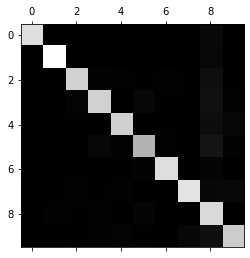

In [24]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix:\n", conf_mx)

#since that's a little difficult to read, making it into a tile plot
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

The confusion matrix looks pretty good as the highest values are on the main diagonal, meaning most digits are classified correctly, though it's difficult to see much detail around the errors.  In order to focus on errors I'm going to divide each value by the number of corresponding images in the dataset to get the error rate, fill the diagonals with zeros (irrelevant when looking at errors), and make another confusion matrix.

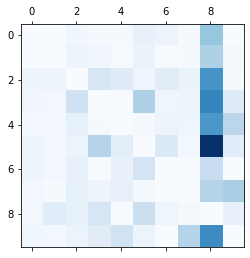

In [32]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums
np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap=plt.cm.Blues)
plt.show()

Keeping in mind that rows represent true classes and columns represent predicted classes, we can draw the following conclusions from the confusion matrix:
- There are a lot of errors in the 8 column, meaning many digits are misclassified as 8s.
- Despite above, the 8 row looks pretty good which means most 8s are correctly classified as 8s.
- 3s and 5s tend to be mistaken for each other in both directions.

From this analysis it's clear that time should be spent on reducing flase 8s.  This could be accomplished a number of ways including training on new data that look like 8s but are not, engineering new features such as number of closed loops, preprocessing images, etc.  

It's also possible to look at individual errors to gain insight, though this can be quite time consuming.  Below I'll look at some examples of 3s and 5s, both correctly and incorrectly classified.

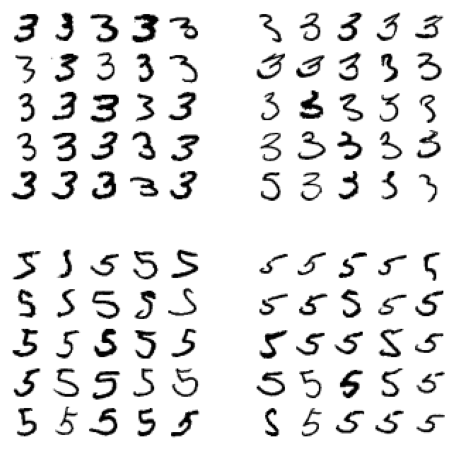

In [40]:
#function to plot matrix of images
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

#pull examples of each combination of 3 & 5
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

#display 25 images from each
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)




In the image above, the main diagonal represent correctly classified images while top right and bottom left contain incorrectly classified images.  Some of the incorrectly classified images seem legitimately difficult to classify to the human eye due to poor writing but most of the misclassified images seem like obvious mistakes.  The truth of the matter is that we used a simple `SDGClassifier` here which is a linear model.  It simply assigns a weight per class for each pixel and then when it encounters new observations it simply sums up the weighted pixel intensities to get a score for each class.  Since 3s and 5s differ only by a few pixels it's no wonder the classifier is poor at distinguishing them.  

# Multilabel Classification

Another type of classification problem involves a model which should output multiple labels per observation.  For example if a facial recognition model is trained to identify three faces, then it should output three values for each image which correspond to whether or not it identified each of the three faces.  Below, I'm working through a simpler example which looks at the MNIST digits and determines whether each digit is large (>=7) and odd.  It outputs two classes for each image.

In [44]:
from sklearn.neighbors import KNeighborsClassifier

#prepare training labels
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_train_multilabel = np.c_[y_train_large, y_train_odd]

#train knn classifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train_multilabel)

#predict on 5
some_digit_class = knn_clf.predict([some_digit])
print("Is 5 >= 7 and/or odd?\n", some_digit_class)

Is 5 >= 7 and/or odd?
 [[False  True]]


It predicts correcly on our single example of a 5!  

Similar to single class classifiers, there are many ways to evaluate performance and the right approach depends on the project.  One way to determine performance is to determine the $F_1$ score of each individual label and then take the average, which is what I'll do below.  This assumes that all labels should be weighted equally however, which may or may not be the case for any given project.  You may want to give each label a weight equal to its _support_ (i.e., the number of instances with that target label).  To do this simply set `average = 'weighted'`.

In [45]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train_multilabel, cv=3)
f1_macro = f1_score(y_train_multilabel, y_train_knn_pred, average='macro')
f1_weighted = f1_score(y_train_multilabel, y_train_knn_pred, average='weighted')

print(f'''
Average F1 score = {f1_macro}
Weighted Average F1 score = {f1_weighted}
''')


Average F1 score = 0.976410265560605
Weighted Average F1 score = 0.9778357403921755



# Multioutput Classification

The final type of classification discussed in this chapter is _multioutput-multiclas classification_ or simply _multioutput classification_ which is simply a generalization of multilabel classification where each label can be multiclass, meaning each label can have more than 2 possible classes. The example below is going to take noisy images and output clean digit images that look like the MNIST images.

First, we're going to generate the training set by taking the MNIST images and adding noise to them by using NumPy's `randint()` function.  The target images will be the original images.

In [50]:
#generate some random noise
num_rows, num_columns = X_train.shape
noise = np.random.randint(0, 100, (num_rows, num_columns))
#add noise to X_train 
X_train_mod = X_train + noise

#generate some random noise
num_rows, num_columns = X_test.shape
noise = np.random.randint(0, 100, (num_rows, num_columns))
#add noise to X_test 
X_test_mod = X_test + noise

#assign original images as target images
y_train_mod = X_train
y_test_mod = X_test


Now if we take a quick look at an example from the test set where the left image is the newly generated noisy image and the right is the original, now target, image.

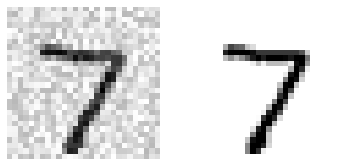

In [52]:
#function to make plotting a single digit easier
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

Ok so now lets train the classifier and generate a prediction from the left image to see if it resembles the right image.

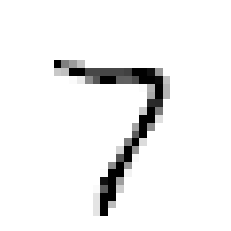

In [54]:
knn_clf.fit(X_train_mod, y_train_mod)
pred_clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(pred_clean_digit)

Looks pretty close to the original image to me!